In [1]:
# from scipy.interpolate import griddata
import xarray as xr
import dask as da
import numpy as np
import pandas as pd
from warnings import filterwarnings as fw
fw('ignore')

import gsw
from tqdm.notebook import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/home/theospira/notebooks/projects/WW_climatology/functions/')
# from plot_formatting import circular_boundary,plot_nice_box
import inspection_funcs as inspf
from inspection_funcs import boxplot

# hydrographic profiles dataset: QC and add mld

## QC

In [3]:
ds = xr.open_dataset('/home/theospira/notebooks/data/SO_2004-2021_2dbar_interp_w_mld.nc')
ds['n_prof'] = np.arange(ds.n_prof.size)
ds

<xarray.Dataset>
Dimensions:  (n_prof: 814697, pres: 501)
Coordinates:
    lon      (n_prof) float64 ...
    lat      (n_prof) float64 ...
    time     (n_prof) datetime64[ns] ...
  * n_prof   (n_prof) int64 0 1 2 3 4 5 ... 814692 814693 814694 814695 814696
  * pres     (pres) int64 0 2 4 6 8 10 12 14 ... 988 990 992 994 996 998 1000
Data variables:
    temp     (n_prof, pres) float64 ...
    psal     (n_prof, pres) float64 ...
    dsource  (n_prof) object ...
    mld      (n_prof) float64 ...
Attributes:
    description:  Interpolated dataset from 2004 to 2021. Contains MLD from p...

In [4]:
ds.n_prof.size

814697

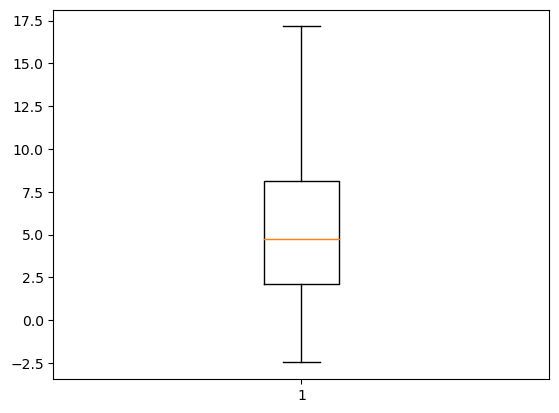

In [10]:
boxplot(ds.temp,showfliers=False)

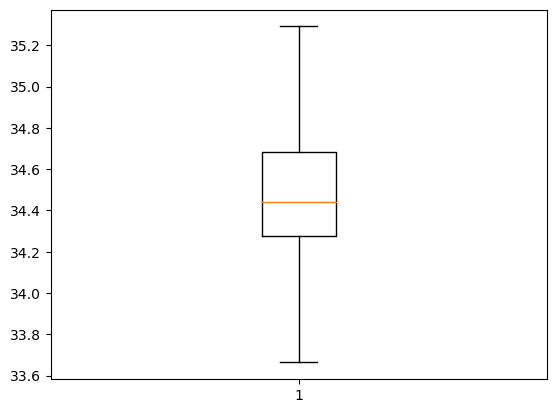

In [9]:
boxplot(ds.psal,showfliers=False)

In [6]:
print('T max: ', ds.temp.max().values)
print('T min: ', ds.temp.min().values)
print('S max: ', ds.psal.max().values)
print('S min: ', ds.psal.min().values)

T max:  50.09000289440155
T min:  -10000000000.0
S max:  99999.0462499857
S min:  -10000000000.0


### based on temp and psal boxplots, drop outlier T&S (cross-referenced with already existing ds). 

running the following code:
```python
saf = (ds.adt - -0.1).__abs__().idxmin(dim='lat')
print('psal max south of saf',ds.psal.where(ds.lat <= saf).max().data)
print('temp max south of saf',ds.temp.where(ds.lat <= saf).max().data)

print('psal min south of saf',ds.psal.where(ds.lat <= saf).min().data)
print('temp min south of saf',ds.temp.where(ds.lat <= saf).min().data)
```
gets the following output:
```
psal max south of saf 35.49643516540254
temp max south of saf 15.569999694824219
psal min south of saf 0.03
temp min south of saf -2.054331537336111
```
from the notebook:
```python 
'notebooks/projects/WW/WW_extent_ssh.ipynb' under markdown title 'quickly checking something'
``` 

In [24]:
ds

<xarray.Dataset>
Dimensions:  (n_prof: 810010, pres: 501)
Coordinates:
    lon      (n_prof) float64 ...
    lat      (n_prof) float64 ...
    time     (n_prof) datetime64[ns] ...
  * n_prof   (n_prof) int64 299620 112768 220 299619 ... 563389 563388 112036
  * pres     (pres) int64 0 2 4 6 8 10 12 14 ... 988 990 992 994 996 998 1000
Data variables:
    asal     (n_prof, pres) float32 ...
    ctemp    (n_prof, pres) float32 ...
    mlp      (n_prof) int64 ...
Attributes:
    description:  Interpolated dataset from 2004 to 2021. Contains MLD from p...

In [11]:
ds = ds.drop_isel(n_prof = np.unique(np.where(ds.temp>16)[0]))
ds = ds.drop_isel(n_prof = np.unique(np.where(ds.temp<-2.5)[0]))
ds = ds.drop_isel(n_prof = np.unique(np.where(ds.temp>16)[0]))
ds = ds.drop_isel(n_prof = np.unique(np.where(ds.temp<-2.5)[0]))

ds = ds.drop_isel(n_prof = np.unique(np.where(ds.psal>38)[0]))
ds = ds.drop_isel(n_prof = np.unique(np.where(ds.psal<30)[0]))
ds = ds.drop_isel(n_prof = np.unique(np.where(ds.psal>38)[0]))
ds = ds.drop_isel(n_prof = np.unique(np.where(ds.psal<30)[0]))

ds = ds.sortby('time')

In [12]:
print('T max: ', ds.temp.max().values)
print('T min: ', ds.temp.min().values)
print('S max: ', ds.psal.max().values)
print('S min: ', ds.psal.min().values)

T max:  24.999000549316406
T min:  -2.4730000528506935
S max:  37.957
S min:  30.01898193359375


In [13]:
ds.n_prof.size

811991

## add variables that I want from GSW

In [ ]:
# introduce absolute solinity into ds using gsw package
ds["asal"]=gsw.SA_from_SP(ds["psal"],ds["pres"]/1000,ds["lon"],ds["lat"]).astype("float32")
ds["asal"].name = "Salinity"
ds["asal"].attrs["long_name"] = "Absolute Salinity"
ds["asal"].attrs["standard_name"] = "ASAL"
ds["asal"].attrs["units"] = "g/kg"

# introduce conservative temp into ds using gsw package
ds["ctemp"]=gsw.CT_from_t(ds["asal"],ds["temp"],ds["pres"]/1000).astype("float32")
ds["ctemp"].name = "CT"
ds["ctemp"].attrs["long_name"] = "Conservative Temperature"
ds["ctemp"].attrs["standard_name"] = "CTEMP"
ds["ctemp"].attrs["units"] = "degrees_Celcius"

## this NEEDS to be calcs using SA and CT!!!
ds["rho"]=gsw.density.rho(ds["asal"],ds["ctemp"],ds["pres"]/1000).astype("float32")
ds["rho"].name = "Density"
ds["rho"].attrs["long_name"] = "In-situ Density"
ds["rho"].attrs["standard_name"] = "rho"
ds["rho"].attrs["units"] = "kg/m^-3"

## add MLP (dbar) calcs as per de Boyer Montegut:  $\Delta \rho$ = 0.03 kg m$^{-3}$ from ref depth of ~10m (we take from 10dbar)

In [ ]:
# remove all profiles that contain only nan density values, ie only temp profs
ds = ds.where(ds.rho.sum(dim='pres') != 0,drop=True) 
# first determine first data point per profile
ref_dpt_idx = ds.rho.isnull().argmin('pres') 
# if ref depth is less than 10dbar, make ref depth 10dbar,
# ie, ref_dept = min(10dbar, first data point ≤ 30m)
ref_dpt_idx = ref_dpt_idx.where(ref_dpt_idx > 5,5)
# remove profiles without data in the top 30dbar
ds = ds.where(ref_dpt_idx<=15,drop=True)
ref_dpt_idx = ds.rho.isnull().argmin('pres') 

# density change as per de Boyer Montegut
den_lim = 0.03

# calc mixed layer pressure
# +5 to acommodate indexing from 5th bin onwards
# *2 to convert from index to dbar
ds['mlp'] = ((np.abs(ds.rho.isel(pres=ref_dpt_idx) - ds.rho.isel(pres=slice(5,2000))
                        ) > den_lim).argmax(dim='pres',skipna=True) +5) *2

# del(ref_dpt_idx) # to save on mem lol

In [ ]:
ds

<xarray.Dataset>
Dimensions:  (n_prof: 810006, pres: 501)
Coordinates:
    lon      (n_prof) float64 -133.5 106.5 -47.64 -118.2 ... -175.1 156.9 -27.04
    lat      (n_prof) float64 -32.29 -33.15 -57.46 ... -34.25 -65.83 -36.08
    time     (n_prof) datetime64[ns] 2004-01-01T06:18:41 ... 2021-12-30T22:50:15
  * n_prof   (n_prof) int64 299620 112768 220 299619 ... 563389 563388 112036
  * pres     (pres) int64 0 2 4 6 8 10 12 14 ... 988 990 992 994 996 998 1000
Data variables:
    temp     (n_prof, pres) float64 nan nan nan 20.77 ... 3.913 3.903 3.894
    psal     (n_prof, pres) float64 nan nan nan 35.37 ... 34.26 34.26 34.26
    dsource  (n_prof) object Argo Argo Argo Argo Argo ... Argo Argo Argo Argo
    mld      (n_prof) float64 38.72 31.37 22.09 15.49 ... 15.84 12.87 15.58
    asal     (n_prof, pres) float32 nan nan nan 35.54 ... 34.42 34.42 34.42
    ctemp    (n_prof, pres) float32 nan nan nan 20.75 ... 3.915 3.905 3.896
    rho      (n_prof, pres) float32 nan nan nan ... 1.027e+03 1.027e+03
    mlp      (n_prof) int64 34 10 18 10 40 14 38 26 ... 72 26 40 10 40 10 12 16
Attributes:
    description:  Interpolated dataset from 2004 to 2021. Contains MLD from p...

In [ ]:
boxplot(ds.mlp,showfliers=False)

In [19]:
ds['dsource']=ds['dsource'].astype(str)

In [20]:
ds.to_netcdf('/home/theospira/notebooks/projects/WW_climatology/profile_ds_2dbar.nc')

## check data looks as it should

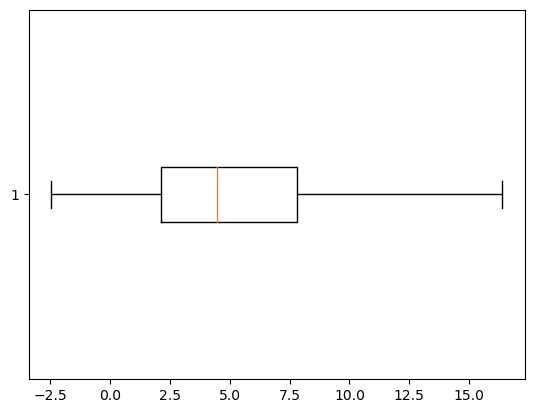

In [108]:
plot_boxplot(dvars[0])

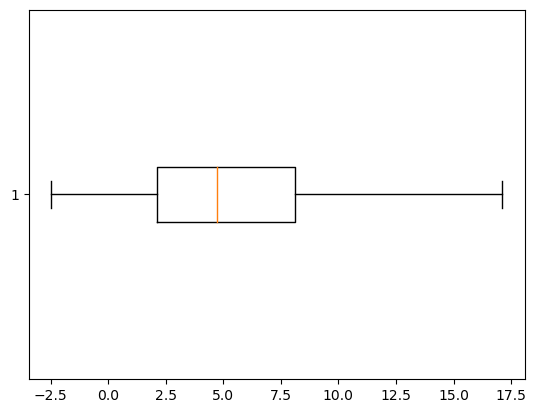

In [109]:
plot_boxplot(ds.temp)

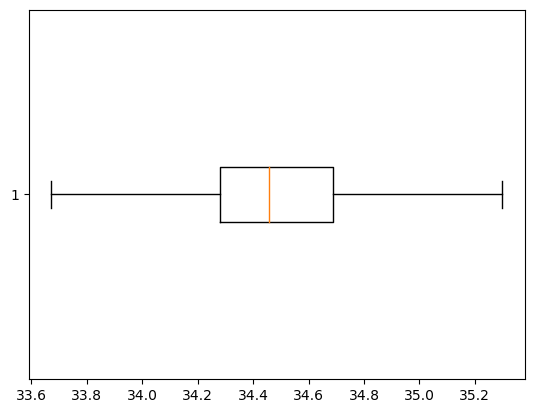

In [110]:
plot_boxplot(dvars[1])

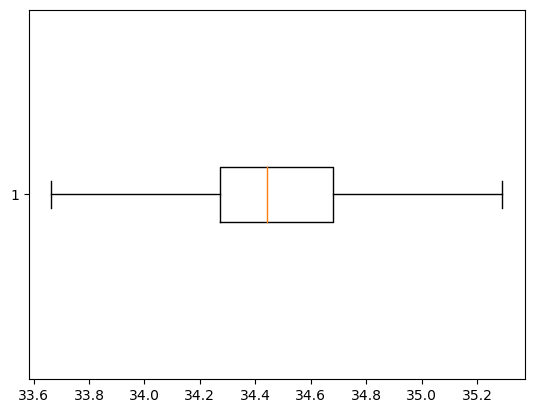

In [111]:
plot_boxplot(ds.psal)

In [116]:
print('T max: ', dvars[0].max().values)
print('T min: ', dvars[0].min().values)
print('S max: ', dvars[1].max().values)
print('S min: ', dvars[1].min().values)

T max:  24.999000549316406
T min:  -2.4730000528506935
S max:  37.637
S min:  0.02449976862563628
The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
